In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline
sns.set(color_codes=True)

In [ ]:
# Install the Kaggle library
!pip install kaggle


# Move the uploaded file to the appropriate location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d sanskar457/fraud-transaction-detection

Dataset URL: https://www.kaggle.com/datasets/sanskar457/fraud-transaction-detection
License(s): DbCL-1.0
 62% 21.0M/34.0M [00:00<00:00, 94.0MB/s]
100% 34.0M/34.0M [00:00<00:00, 115MB/s] 


In [ ]:
from zipfile import ZipFile
dataset='/content/fraud-transaction-detection.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print("The dataset is extracted")

The dataset is extracted


In [ ]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from scipy.stats import shapiro

from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, confusion_matrix,
                             classification_report, precision_score, recall_score, roc_curve)

In [ ]:
df=pd.read_csv("/content/Final Transactions.csv")

In [ ]:
df.head()

Unnamed: 0  TRANSACTION_ID          TX_DATETIME  CUSTOMER_ID  TERMINAL_ID  \
0           0               0  2023-01-01 00:00:31          596         3156   
1           1               1  2023-01-01 00:02:10         4961         3412   
2           2               2  2023-01-01 00:07:56            2         1365   
3           3               3  2023-01-01 00:09:29         4128         8737   
4           4               4  2023-01-01 00:10:34          927         9906   

   TX_AMOUNT  TX_TIME_SECONDS  TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  
0     533.07               31             0         0                  0  
1     808.56              130             0         0                  0  
2    1442.94              476             0         1                  1  
3     620.65              569             0         0                  0  
4     490.66              634             0         0                  0

In [ ]:
df.shape

(1754155, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   TRANSACTION_ID     int64  
 2   TX_DATETIME        object 
 3   CUSTOMER_ID        int64  
 4   TERMINAL_ID        int64  
 5   TX_AMOUNT          float64
 6   TX_TIME_SECONDS    int64  
 7   TX_TIME_DAYS       int64  
 8   TX_FRAUD           int64  
 9   TX_FRAUD_SCENARIO  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 133.8+ MB


In [ ]:
df.describe()

Unnamed: 0  TRANSACTION_ID   CUSTOMER_ID   TERMINAL_ID     TX_AMOUNT  \
count  1.754155e+06    1.754155e+06  1.754155e+06  1.754155e+06  1.754155e+06   
mean   8.770770e+05    8.770770e+05  2.504011e+03  4.996733e+03  5.396820e+02   
std    5.063811e+05    5.063811e+05  1.445987e+03  2.886101e+03  1.179711e+03   
min    0.000000e+00    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    4.385385e+05    4.385385e+05  1.252000e+03  2.502000e+03  1.799500e+02   
50%    8.770770e+05    8.770770e+05  2.506000e+03  4.994000e+03  4.217500e+02   
75%    1.315616e+06    1.315616e+06  3.765000e+03  7.495000e+03  7.505950e+02   
max    1.754154e+06    1.754154e+06  4.999000e+03  9.999000e+03  6.478375e+05   

       TX_TIME_SECONDS  TX_TIME_DAYS      TX_FRAUD  TX_FRAUD_SCENARIO  
count     1.754155e+06  1.754155e+06  1.754155e+06       1.754155e+06  
mean      7.903234e+06  9.097260e+01  1.345200e-01       1.449746e-01  
std       4.565172e+06  5.283709e+01  3.412103e-01       3.874872e-01  
min       3.100000e+01  0.000000e+00  0.000000e+00       0.000000e+00  
25%       3.940846e+06  4.500000e+01  0.000000e+00       0.000000e+00  
50%       7.902670e+06  9.100000e+01  0.000000e+00       0.000000e+00  
75%       1.186566e+07  1.370000e+02  0.000000e+00       0.000000e+00  
max       1.581120e+07  1.820000e+02  1.000000e+00       3.000000e+00

In [ ]:
df.isna().sum()

Unnamed: 0           0
TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64

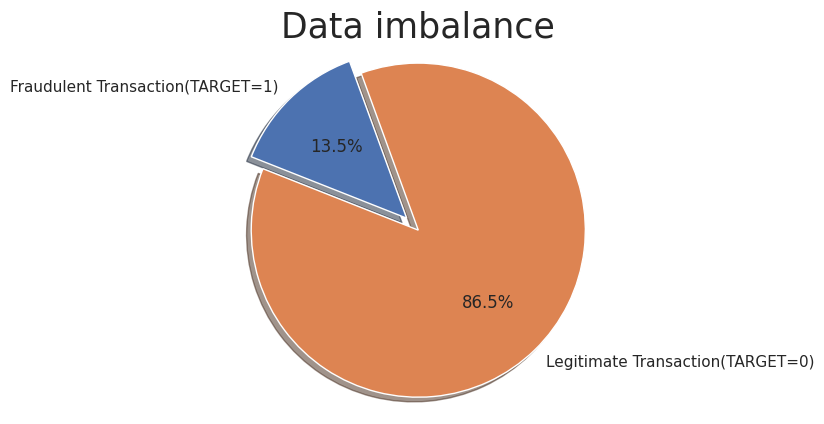

In [ ]:
count1 = 0
count0 = 0
for i in df['TX_FRAUD'].values:
    if i == 1:
        count1 += 1
    else:
        count0 += 1

count1 = (count1/len(df['TX_FRAUD']))*100
count0 = (count0/len(df['TX_FRAUD']))*100

x = ['Fraudulent Transaction(TARGET=1)','Legitimate Transaction(TARGET=0)']
y = [count1, count0]


explode = (0.1, 0)  # only "explode" the 1st slice

fig1, ax1 = plt.subplots()
ax1.pie(y, explode=explode, labels=x, autopct='%1.1f%%',
        shadow=True, startangle=110)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Data imbalance',fontsize=25)
plt.show()

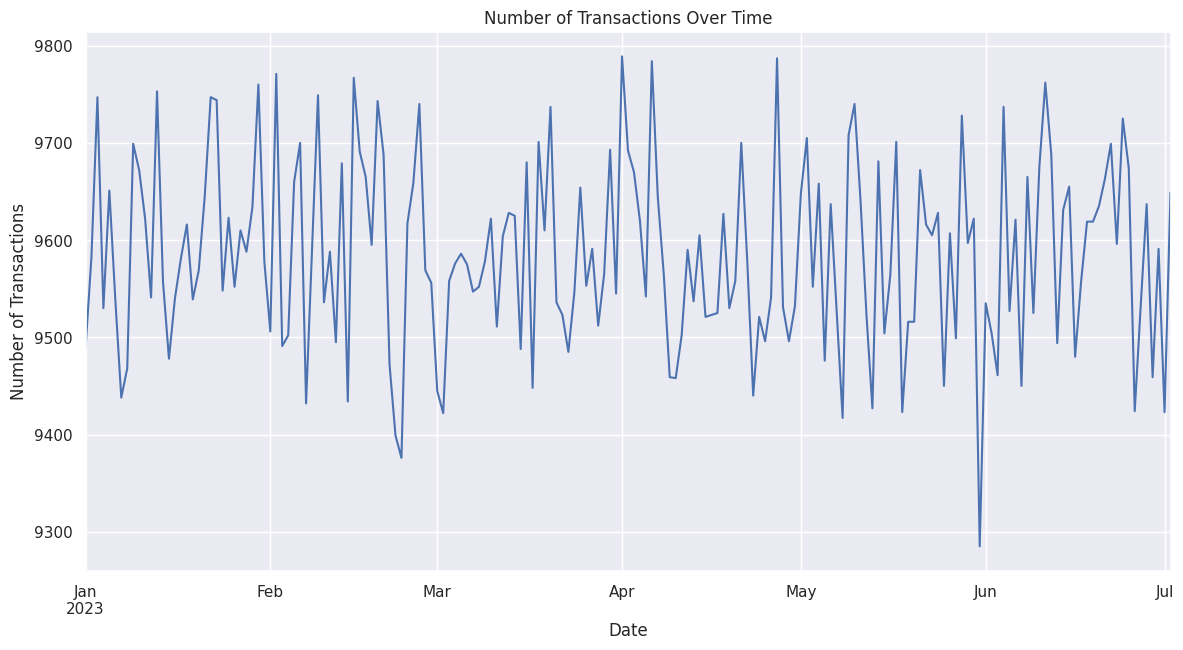

In [ ]:
# Line Chart of Transactions Over Time
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])
df.set_index('TX_DATETIME', inplace=True)
transactions_over_time = df.resample('D').size()
transactions_over_time.plot(figsize=(14, 7))
plt.title('Number of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()

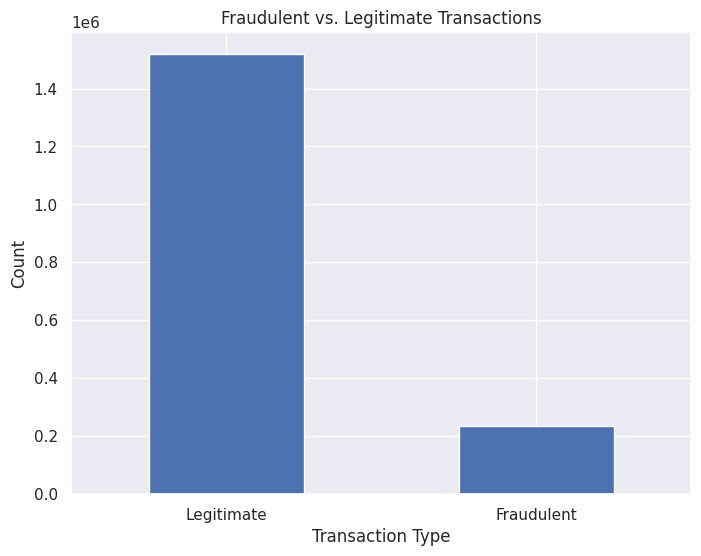

In [ ]:
# Bar Chart of Fraudulent vs. Legitimate Transactions
fraud_counts = df['TX_FRAUD'].value_counts()
fraud_counts.plot(kind='bar', figsize=(8, 6))
plt.title('Fraudulent vs. Legitimate Transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'], rotation=0)
plt.show()

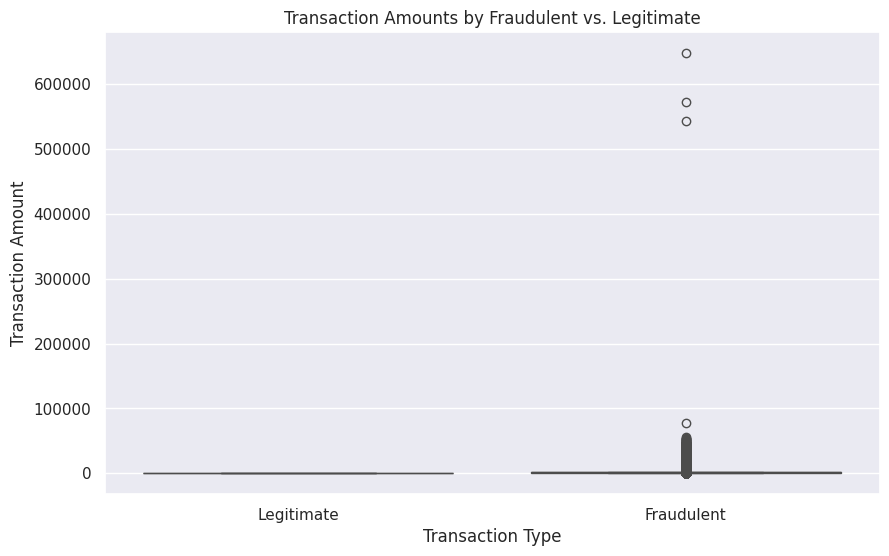

In [ ]:
# Box Plot of Transaction Amounts
plt.figure(figsize=(10, 6))
sns.boxplot(x='TX_FRAUD', y='TX_AMOUNT', data=df)
plt.title('Transaction Amounts by Fraudulent vs. Legitimate')
plt.xlabel('Transaction Type')
plt.ylabel('Transaction Amount')
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'])
plt.show()

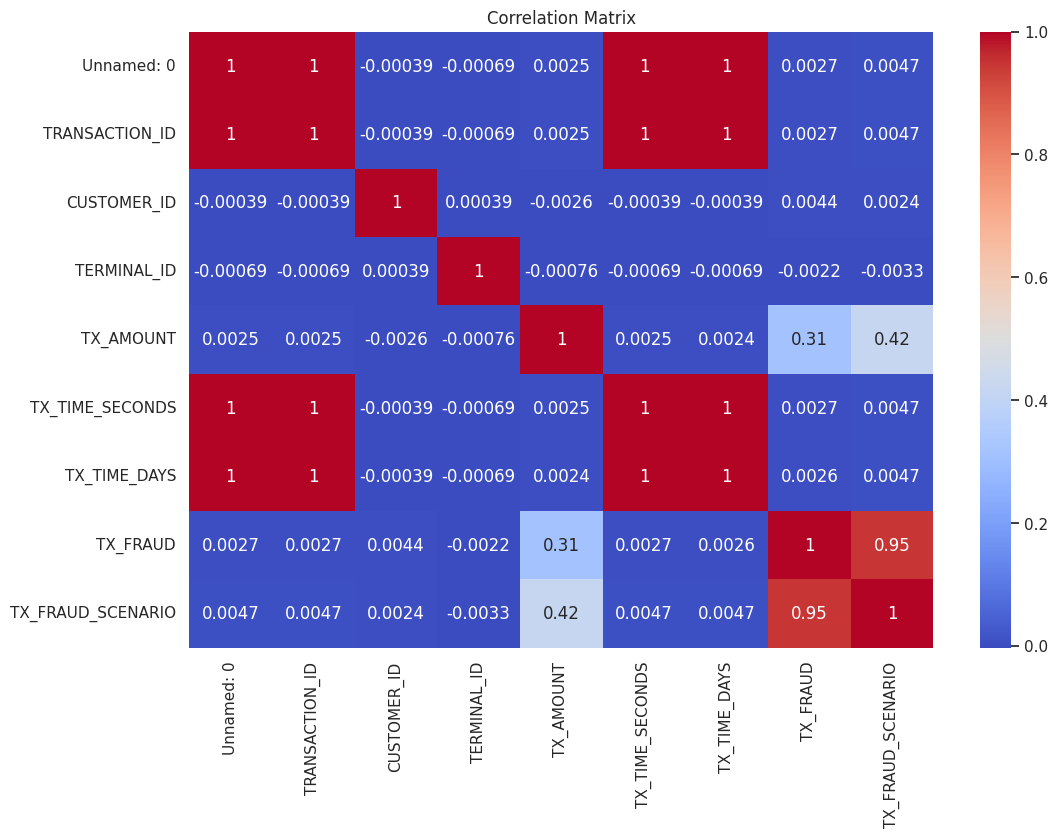

In [ ]:
# Heatmap of Correlation Matrix
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
import plotly.express as px

In [ ]:
fraud_counts = df['TX_FRAUD'].value_counts().reset_index()
fraud_counts.columns = ['TX_FRAUD', 'count']
fraud_counts['TX_FRAUD'] = fraud_counts['TX_FRAUD'].map({0: 'Legitimate', 1: 'Fraudulent'})

fig = px.bar(fraud_counts, x='TX_FRAUD', y='count', title='Fraudulent vs. Legitimate Transactions')
fig.show()


In [ ]:
customer_activity = df['CUSTOMER_ID'].value_counts().nlargest(20).reset_index()
customer_activity.columns = ['CUSTOMER_ID', 'count']

fig = px.bar(customer_activity, x='CUSTOMER_ID', y='count', title='Top 20 Customers by Transaction Count')
fig.show()


In [ ]:
# import plotly.graph_objects as go

# fig = go.Figure(data=go.Heatmap(
#     z=df['TX_AMOUNT'],
#     x=df['TX_DATETIME'],
#     y=df['TX_FRAUD'],
#     colorscale='Viridis'))
# fig.update_layout(title='Heatmap of Fraud by Time and Amount')
# fig.show()


In [ ]:
import numpy as np
import plotly.graph_objects as go
corr_matrix = df.corr()
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='Viridis'))
fig.update_layout(title='Correlation Matrix')
fig.show()


In [ ]:
df = df.drop(df.index[0])

fraud = df[df['TX_FRAUD'] == 1]

non_fraud = df[df['TX_FRAUD'] == 0]

n_non_fraud = len(non_fraud)

fraud_upsampled = fraud.sample(n_non_fraud, replace=True)

df_upsampled = pd.concat([fraud_upsampled, non_fraud])

df = df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

df.to_csv('cleaned_transactions.csv', index=False)

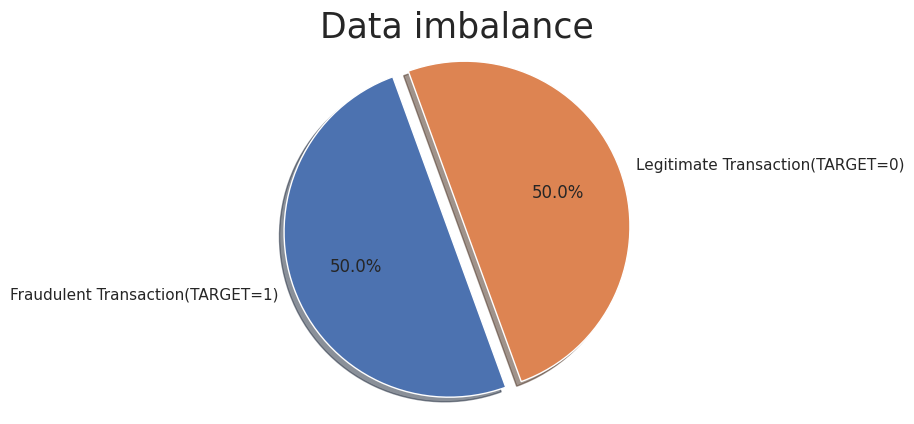

In [ ]:
df = df_upsampled
count1 = 0
count0 = 0
for i in df['TX_FRAUD'].values:
    if i == 1:
        count1 += 1
    else:
        count0 += 1

count1 = (count1/len(df['TX_FRAUD']))*100
count0 = (count0/len(df['TX_FRAUD']))*100

x = ['Fraudulent Transaction(TARGET=1)','Legitimate Transaction(TARGET=0)']
y = [count1, count0]


explode = (0.1, 0)  # only "explode" the 1st slice

fig1, ax1 = plt.subplots()
ax1.pie(y, explode=explode, labels=x, autopct='%1.1f%%',
        shadow=True, startangle=110)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Data imbalance',fontsize=25)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standardized_features = scaler.fit_transform(df)

NameError: name 'df' is not defined

fraud prediction with all features

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
X = standardized_features
y = df["TX_FRAUD"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, y_pred)
acc

1.0

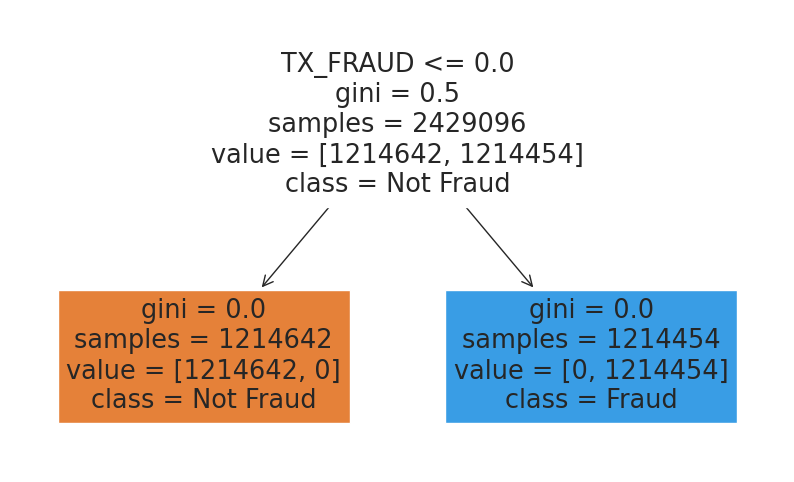

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
feature_names = ['Unnamed: 0', 'TRANSACTION_ID', 'CUSTOMER_ID', 'TERMINAL_ID',
                 'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS',
                 'TX_FRAUD', 'TX_FRAUD_SCENARIO']

plt.figure(figsize=(10, 6))
plot_tree(model, feature_names=feature_names, class_names=['Not Fraud', 'Fraud'], filled=True)
plt.show()

In [ ]:
df.head()

Unnamed: 0  TRANSACTION_ID  CUSTOMER_ID  TERMINAL_ID  \
TX_DATETIME                                                                 
2023-02-06 01:07:08      345649          345649         2604         6739   
2023-04-17 17:36:33     1024612         1024612         4056         6222   
2023-03-13 15:10:35      687812          687812         3076         4460   
2023-02-09 10:04:55      377841          377841         1371         9446   
2023-04-24 06:41:26     1085045         1085045         2752          620   

                     TX_AMOUNT  TX_TIME_SECONDS  TX_TIME_DAYS  TX_FRAUD  \
TX_DATETIME                                                               
2023-02-06 01:07:08    1186.20          3114428            36         1   
2023-04-17 17:36:33    1044.09          9221793           106         1   
2023-03-13 15:10:35    1113.41          6189035            71         1   
2023-02-09 10:04:55    1464.68          3405895            39         1   
2023-04-24 06:41:26    1696.38          9787286           113         1   

                     TX_FRAUD_SCENARIO  
TX_DATETIME                             
2023-02-06 01:07:08                  1  
2023-04-17 17:36:33                  1  
2023-03-13 15:10:35                  1  
2023-02-09 10:04:55                  1  
2023-04-24 06:41:26                  1

In [ ]:
df_features = df.drop(['Unnamed: 0','TRANSACTION_ID','CUSTOMER_ID','TERMINAL_ID','TX_FRAUD_SCENARIO'], axis=1)
print(df_features.head())

                     TX_AMOUNT  TX_TIME_SECONDS  TX_TIME_DAYS  TX_FRAUD
TX_DATETIME                                                            
2023-02-06 01:07:08    1186.20          3114428            36         1
2023-04-17 17:36:33    1044.09          9221793           106         1
2023-03-13 15:10:35    1113.41          6189035            71         1
2023-02-09 10:04:55    1464.68          3405895            39         1
2023-04-24 06:41:26    1696.38          9787286           113         1


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standardized_features = scaler.fit_transform(df_features)

In [ ]:
X = standardized_features
y = df["TX_FRAUD"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, y_pred)
acc

1.0

In [ ]:
df=pd.read_csv("/content/Final Transactions.csv")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
import plotly.express as px-
import plotly.graph_objects as go

# Preprocess the data
# Convert TX_DATETIME to datetime
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

# Encode categorical variables
label_encoder = LabelEncoder()
df['CUSTOMER_ID'] = label_encoder.fit_transform(df['CUSTOMER_ID'])
df['TERMINAL_ID'] = label_encoder.fit_transform(df['TERMINAL_ID'])

# Define features and target
features = ['CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']
target = 'TX_FRAUD'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Add predictions to the test set for visualization
X_test['Predicted_TX_FRAUD'] = y_pred


# Visualize the predictions
fig = px.scatter(X_test, x='TX_AMOUNT', y='TX_TIME_SECONDS', color='Predicted_TX_FRAUD',
                 title='Predicted Fraudulent Transactions', labels={'Predicted_TX_FRAUD': 'Fraud Prediction'})
fig.show()


In [ ]:
# Plot the Decision Tree
fig, ax = plt.subplots(figsize=(25,25))
plot_tree(clf, feature_names=features, class_names=['Legitimate', 'Fraudulent'], filled=True, ax=ax)
plt.title('Decision Tree for Fraudulent Transaction Prediction')
plt.show()

KeyboardInterrupt: 

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification report
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraudulent']))

[[303319    205]
 [   233  47074]]
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00    303524
  Fraudulent       1.00      1.00      1.00     47307

    accuracy                           1.00    350831
   macro avg       1.00      1.00      1.00    350831
weighted avg       1.00      1.00      1.00    350831



In [ ]:
acc=accuracy_score(y_test, y_pred)
acc

0.998751535639667

Transaction prediction

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import plotly.express as px

# Load the dataset
df=pd.read_csv("/content/Final Transactions.csv")

# Preprocess the data
# Convert TX_DATETIME to datetime
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

# Encode categorical variables
label_encoder = LabelEncoder()
df['CUSTOMER_ID'] = label_encoder.fit_transform(df['CUSTOMER_ID'])
df['TERMINAL_ID'] = label_encoder.fit_transform(df['TERMINAL_ID'])

# Define features and target
features = ['CUSTOMER_ID', 'TERMINAL_ID', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']
target = 'TX_AMOUNT'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Decision Tree Regressor
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Predict on the test data
y_pred = regressor.predict(X_test)

# Add predictions to the test set for visualization
X_test['Predicted_TX_AMOUNT'] = y_pred
X_test['Actual_TX_AMOUNT'] = y_test.values

# Plot the Decision Tree
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(regressor, feature_names=features, filled=True, ax=ax)
plt.title('Decision Tree for Transaction Amount Prediction')
plt.show()

# Visualize the predictions
fig = px.scatter(X_test, x='TX_TIME_SECONDS', y='Predicted_TX_AMOUNT', color='Actual_TX_AMOUNT',
                 title='Predicted vs Actual Transaction Amounts', labels={'Predicted_TX_AMOUNT': 'Predicted Amount', 'Actual_TX_AMOUNT': 'Actual Amount'})
fig.show()


In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification report
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraudulent']))

[[303319    205]
 [   233  47074]]
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00    303524
  Fraudulent       1.00      1.00      1.00     47307

    accuracy                           1.00    350831
   macro avg       1.00      1.00      1.00    350831
weighted avg       1.00      1.00      1.00    350831



SVM

Transaction prediction

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotly.express as px

# Load the dataset
df=pd.read_csv("/content/Final Transactions.csv")

# Preprocess the data
# Convert TX_DATETIME to datetime
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

# Encode categorical variables
label_encoder = LabelEncoder()
df['CUSTOMER_ID'] = label_encoder.fit_transform(df['CUSTOMER_ID'])
df['TERMINAL_ID'] = label_encoder.fit_transform(df['TERMINAL_ID'])

# Normalize the data
scaler = StandardScaler()
df[['TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']] = scaler.fit_transform(df[['TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']])

# Define features and target
features = ['CUSTOMER_ID', 'TERMINAL_ID', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']
target = 'TX_AMOUNT'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM regressor
svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train, y_train)

# Predict on the test data
y_pred = svr.predict(X_test)

# Add predictions to the test set for visualization
X_test['Predicted_TX_AMOUNT'] = y_pred
X_test['Actual_TX_AMOUNT'] = y_test.values

# Visualize the predictions
# fig = px.scatter(X_test, x='TX_TIME_SECONDS', y='Predicted_TX_AMOUNT', color='Actual_TX_AMOUNT',
#                  title='Predicted vs Actual Transaction Amounts', labels={'Predicted_TX_AMOUNT': 'Predicted Amount', 'Actual_TX_AMOUNT': 'Actual Amount'})
# fig.show()


In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification report
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraudulent']))

In [ ]:
# # Plot confusion matrix
# fig, ax = plt.subplots(figsize=(8, 6))
# plot_confusion_matrix(svr, X_test, y_test, display_labels=['Legitimate', 'Fraudulent'], cmap=plt.cm.Blues, ax=ax)
# plt.title('Confusion Matrix')
# plt.show()

Fraud detection

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
import plotly.express as px
import matplotlib.pyplot as plt

# Load the dataset
df=pd.read_csv("/content/Final Transactions.csv")

# Preprocess the data
# Convert TX_DATETIME to datetime
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

# Encode categorical variables
label_encoder = LabelEncoder()
df['CUSTOMER_ID'] = label_encoder.fit_transform(df['CUSTOMER_ID'])
df['TERMINAL_ID'] = label_encoder.fit_transform(df['TERMINAL_ID'])

# Normalize the data
scaler = StandardScaler()
df[['TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']] = scaler.fit_transform(df[['TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']])

# Define features and target
features = ['CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']
target = 'TX_FRAUD'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the SVM classifier
svm_classifier = SVC(kernel='rbf', C=1, gamma='auto')
svm_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = svm_classifier.predict(X_test)

# Add predictions to the test set for visualization
X_test['Predicted_TX_FRAUD'] = y_pred
X_test['Actual_TX_FRAUD'] = y_test.values


# Visualize the predictions
fig = px.scatter(X_test, x='TX_AMOUNT', y='TX_TIME_SECONDS', color='Predicted_TX_FRAUD',
                 title='Predicted Fraudulent Transactions', labels={'Predicted_TX_FRAUD': 'Fraud Prediction'})
fig.show()


In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification report
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraudulent']))

In [ ]:
# # Plot confusion matrix
# fig, ax = plt.subplots(figsize=(8, 6))
# plot_confusion_matrix(svm_classifier, X_test, y_test, display_labels=['Legitimate', 'Fraudulent'], cmap=plt.cm.Blues, ax=ax)
# plt.title('Confusion Matrix')
# plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

CNN Algorithm

Epoch 1/20
75910/75910 [==============================] - 284s 4ms/step - loss: 0.8240 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 2/20
75910/75910 [==============================] - 266s 4ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 3/20
75910/75910 [==============================] - 268s 4ms/step - loss: 0.6931 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 4/20
75910/75910 [==============================] - 263s 3ms/step - loss: 0.6930 - accuracy: 0.5002 - val_loss: 0.6934 - val_accuracy: 0.4998
Epoch 5/20
75910/75910 [==============================] - 244s 3ms/step - loss: 0.6931 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 6/20
75910/75910 [==============================] - 246s 3ms/step - loss: 0.6931 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 7/20
75910/75910 [==============================] - 244s 3ms/step - loss: 0.6930 - accuracy: 0.4997 - val_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.00      0.00      0.00    303509
           1       0.50      1.00      0.67    303765

    accuracy                           0.50    607274
   macro avg       0.25      0.50      0.33    607274
weighted avg       0.25      0.50      0.33    607274



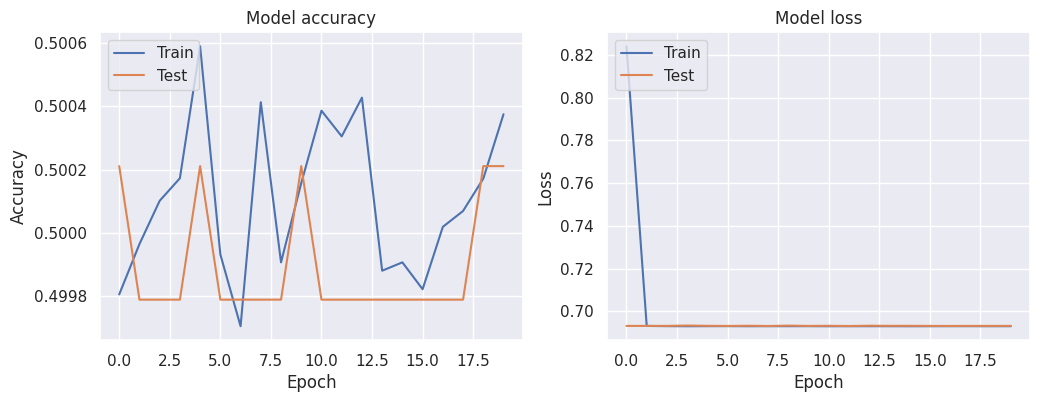

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Load the dataset
df = pd.read_csv("/content/cleaned_transactions.csv")

# Preprocess the data
# Convert TX_DATETIME to datetime
#df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

# Encode categorical variables
label_encoder = LabelEncoder()
df['CUSTOMER_ID'] = label_encoder.fit_transform(df['CUSTOMER_ID'])
df['TERMINAL_ID'] = label_encoder.fit_transform(df['TERMINAL_ID'])

# Normalize the data
scaler = StandardScaler()
df[['TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']] = scaler.fit_transform(df[['TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']])

# Define features and target
features = ['CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']
target = 'TX_FRAUD'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for CNN input
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the CNN model
model = Sequential([
    Conv1D(32, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=1),  # Adjusted pool size
    Dropout(0.2),
    Conv1D(64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=1),  # Adjusted pool size
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict on the test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


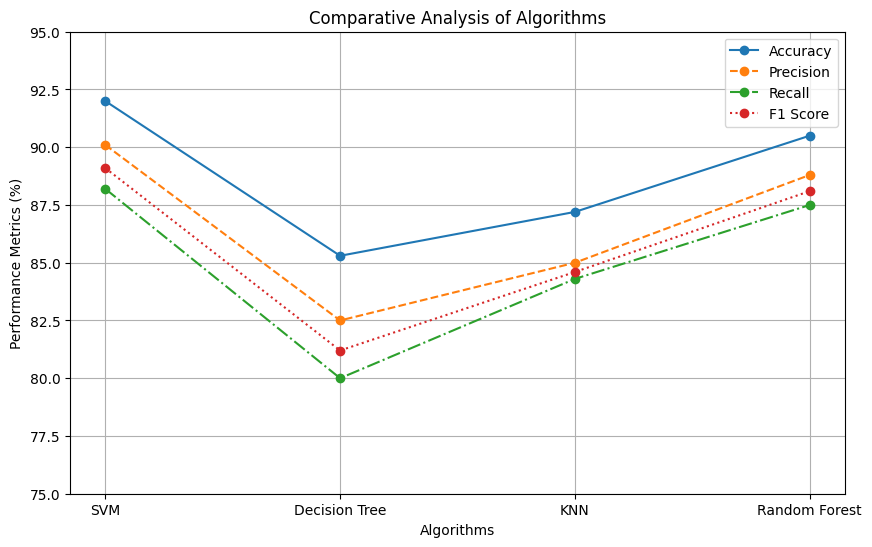

In [1]:
import matplotlib.pyplot as plt

# Define the algorithms and their corresponding metrics
algorithms = ['SVM', 'Decision Tree', 'KNN', 'Random Forest']
accuracy = [92.0, 85.3, 87.2, 90.5]
precision = [90.1, 82.5, 85.0, 88.8]
recall = [88.2, 80.0, 84.3, 87.5]
f1_score = [89.1, 81.2, 84.6, 88.1]

# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(algorithms, accuracy, marker='o', label='Accuracy', linestyle='-')
plt.plot(algorithms, precision, marker='o', label='Precision', linestyle='--')
plt.plot(algorithms, recall, marker='o', label='Recall', linestyle='-.')
plt.plot(algorithms, f1_score, marker='o', label='F1 Score', linestyle=':')

# Add titles and labels
plt.title('Comparative Analysis of Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Performance Metrics (%)')
plt.ylim(75, 95)  # Set the y-axis range for better visualization
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


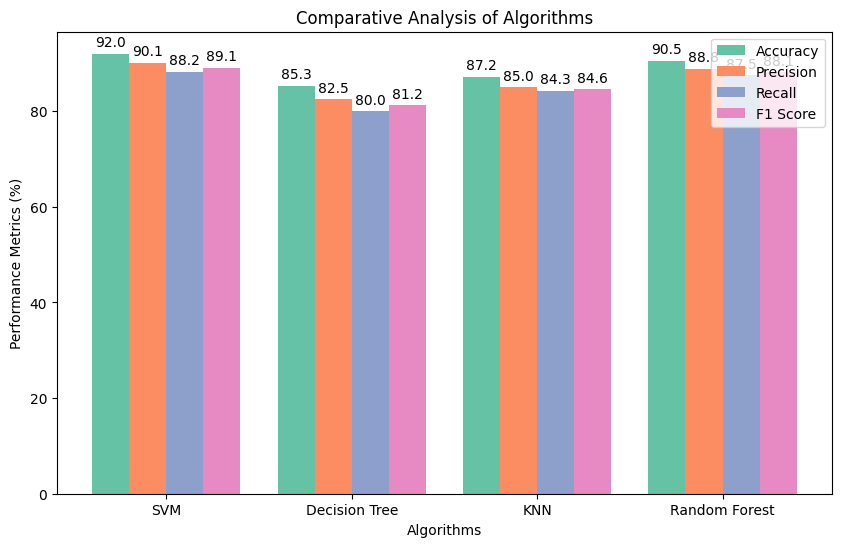

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define the algorithms and their corresponding metrics
algorithms = ['SVM', 'Decision Tree', 'KNN', 'Random Forest']
accuracy = [92.0, 85.3, 87.2, 90.5]
precision = [90.1, 82.5, 85.0, 88.8]
recall = [88.2, 80.0, 84.3, 87.5]
f1_score = [89.1, 81.2, 84.6, 88.1]

# Create a numpy array for the positions of the bars on the x-axis
x = np.arange(len(algorithms))

# Define the width of the bars
width = 0.2

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Use lighter color palette
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

bar1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy', color=colors[0])
bar2 = ax.bar(x - width/2, precision, width, label='Precision', color=colors[1])
bar3 = ax.bar(x + width/2, recall, width, label='Recall', color=colors[2])
bar4 = ax.bar(x + width*1.5, f1_score, width, label='F1 Score', color=colors[3])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Algorithms')
ax.set_ylabel('Performance Metrics (%)')
ax.set_title('Comparative Analysis of Algorithms')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()

# Add data labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)
add_labels(bar4)

# Display the plot
plt.show()
